# Visualize graph obtained from pycausal analysis

In [1]:
import pandas as pd
import pycausal
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
import glob
import os
from os.path import join as pjoin
from IPython.display import SVG
import pylab
import matplotlib.pyplot as plt

## functions to get graph

In [2]:
def getdfs(csvdir):
    """
    give us list of data frames for csv files in directory.
    """
    dfs = []
    for csvfile in glob.glob(csvdir + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

In [3]:
def run_images_lofs(dfs,
                    withlofs=True,
                    lofsrule='R3',
                    lofsscore='andersonDarling',
                    maxdegree=30,
                    penalty=4):
    """
    run IMaGES and optionally LOFS post-processing on a given list of dataframes.
    Return the graph instance of either images or lofs output.
    """
    pc.start_vm() 
    
    images = s.imagesSemBic(dfs, verbose=True, maxDegree=maxdegree, penaltyDiscount=penalty)
    if withlofs:
        tetradGraph = images.getTetradGraph()    
        lofs = s.lofs(tetradGraph, dfs, dataType=0, rule=lofsrule, score=lofsscore)
    
        pc.stop_vm()
        return lofs
    else:
        pc.stop_vm()
        return images

In [4]:
def plot_svg(images_instance):
    """
    Take graph instance from IMaGES or LOFS and plot the SVG.
    """
    dot = images_instance.getDot()
    svg_str = dot.create_svg(prog='dot')
    svg = SVG(svg_str)
    return svg

## run IMaGES + LOFS on residual data

In [5]:
dfs = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance', 'csv', 'run*'))

In [6]:
lofs = run_images_lofs(dfs)

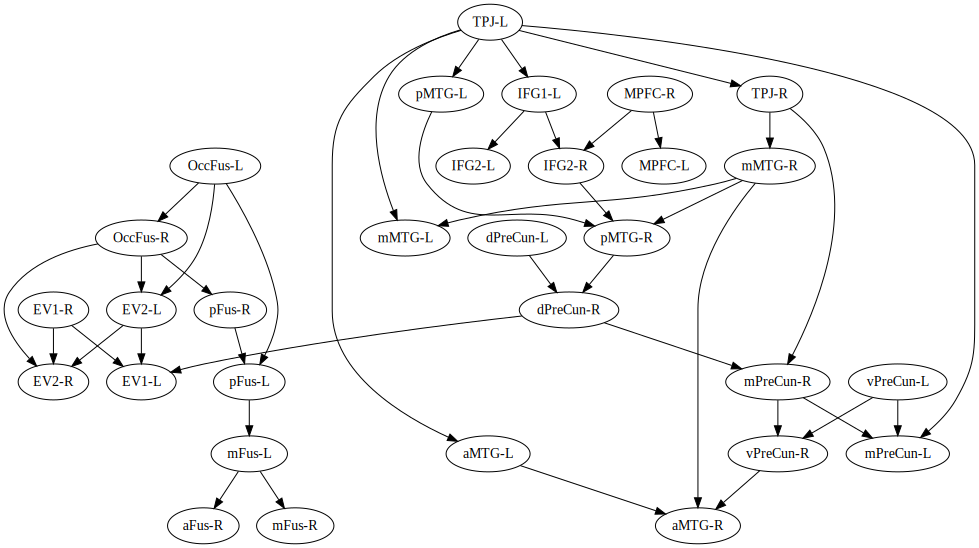

In [7]:
plot_svg(lofs)

## pycausal to networkx graph

In [8]:
def pc2nx(images_instance):
    """
    Take the result from IMaGES or IMaGES+LOFS and return
    a networkx directed multigraph.
    """
    G = nx.drawing.nx_pydot.from_pydot(images_instance.graph)
    return G

In [9]:
G = pc2nx(lofs)

## visualize with networkx

In [10]:
# create different node layouts/positions to try out
spring_pos = nx.spring_layout(G, iterations=1000)
spec_pos = nx.spectral_layout(G)
rand_pos = nx.random_layout(G)
shell_pos = nx.shell_layout(G) # same as circular
circ_pos = nx.circular_layout(G)

In [11]:
# get real ROI coordinates

def create_posdict(infile):
    """
    Create dictionary with node name as key and XY coordinates
    as values from a CSV file
    """
    import csv
    import numpy as np
    
    # read csv file
    with open(infile, 'rb') as csvfile:
        rdr = csv.reader(csvfile, delimiter=',')
        data = [row for row in rdr]

    # seperate nodes and coordinates
    xy = np.array([map(int, row[1:-1]) for row in data[1:]])
    nodes = [row[0].replace(' ', '') for row in data[1:]]

    # map to dict
    posdict = dict()
    for node, coord in zip(nodes, xy):
        posdict[node] = coord
    
    return posdict

In [12]:
coords_file = '/host/famfaces/rois/tetrad/roi_coord_30.csv'
roi_pos = create_posdict(coords_file)
#print(roi_pos)

In [13]:
# node colors based on core/extended system

nodecolors = []

for node in roi_pos.keys():
    if 'EV' in node:
        nodecolors.append('#0000FF')
    elif 'Fus' in node:
        nodecolors.append('#e41a1a')
    elif 'MPFC' in node or 'TPJ' in node:
        nodecolors.append('#008100')
    elif 'IFG' in node:
        nodecolors.append('#e4a11a')
    elif 'MTG' in node:
        nodecolors.append('#b1551c')
    elif 'PreCun' in node:
        nodecolors.append('#099997')
    else:
        nodecolors.append('black') # fallback

In [14]:
# adjust style with seaborn
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

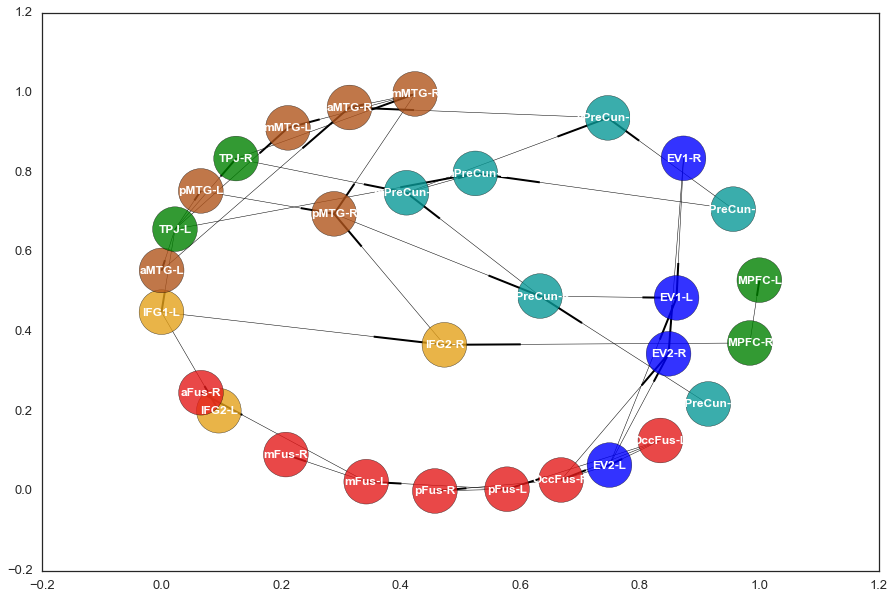

In [34]:
# initiate figure
plt.figure(3,figsize=(15,10)) 

# draw nodes, edges and labels
nx.draw_networkx_nodes(G, pos=spring_pos, node_size=2000, node_color=nodecolors, alpha=.8)
nx.draw_networkx_edges(G, pos=spring_pos, alpha=1, arrows=True, width=.5)
nx.draw_networkx_labels(G, pos=spring_pos, font_size=12, font_family='sans-serif', font_weight='bold', font_color='white')

plt.show()

In [16]:
# nx.draw?

In [17]:
# nx.draw_networkx?

# visualize pydot resulting from images+lofs

In [18]:
# see nodes of dot file
pydot_nodes = [node.get_name() for node in lofs.graph.get_nodes()]
# pydot_nodes

In [ ]:
for node in roi_pos.keys():
    if 'EV' in node:
        nodecolors.append('#0000FF')
    elif 'Fus' in node:
        nodecolors.append('#e41a1a')
    elif 'MPFC' in node or 'TPJ' in node:
        nodecolors.append('#008100')
    elif 'IFG' in node:
        nodecolors.append('#e4a11a')
    elif 'MTG' in node:
        nodecolors.append('#b1551c')
    elif 'PreCun' in node:
        nodecolors.append('#099997')
    else:
        nodecolors.append('black') # fallback

In [28]:
"""
Change node colors in pydot instance from lofs/images
"""

for node in lofs.graph.get_nodes():
    if 'EV' in node.get_name():
        node.set_color('#0000FF')
    elif 'Fus' in node.get_name():
        node.set_color( '#e41a1a')
    elif 'MPFC' in node.get_name() or 'TPJ' in node.get_name():
        node.set_color('#008100')
    elif 'IFG' in node.get_name():
        node.set_color('#e4a11a')
    elif 'MTG' in node.get_name():
        node.set_color('#b1551c')
    elif 'PreCun' in node.get_name():
        node.set_color('#099997')
    else:
        node.set_color('black') # fallback

In [29]:
"""
Change width of circle around nodes and font type
"""

for node in lofs.graph.get_nodes():
    node.set_penwidth(3)
    node.set_fontname('helvetica-bold')

Sadly, there seems to be no way to add a legend in the pydot framework

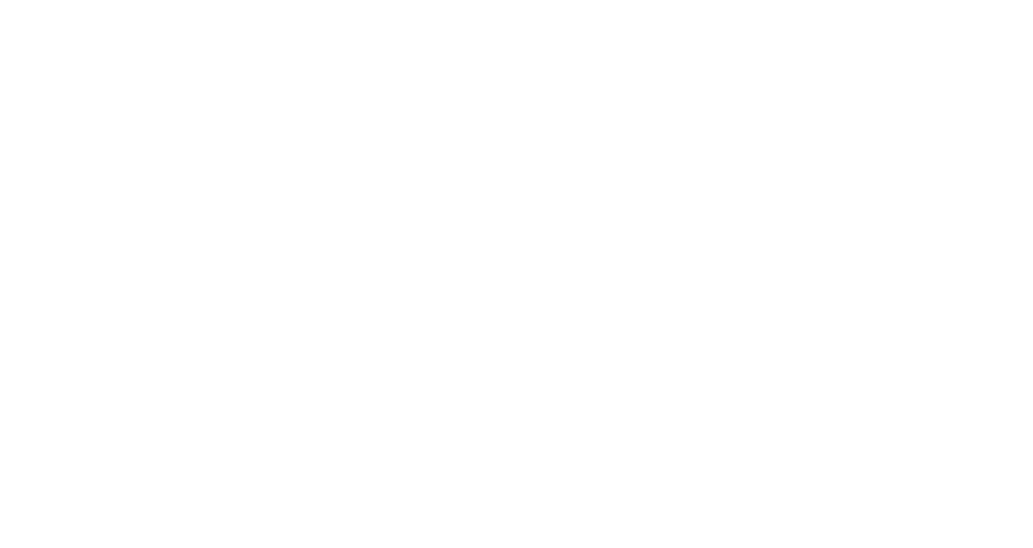

In [32]:
plot_svg(lofs)

In [31]:
# save to png
def save_images2png(images_instance, outname, dpi=300):
    dot = images_instance.getDot()
    dot.set_dpi(300)
    dot.write_png(outname)
    
save_images2png(lofs,'lofs_residuals_color.png')